In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
import numpy as np
import os
import sklearn.linear_model
import matplotlib.pyplot as plt

target_directory = './resources/run_1'
target_filename = 'small'

X_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainX.csv"), delimiter=',')
Y_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainY.csv"), delimiter=',')

print('Succesfully imported dataset with of size {0}'.format(X_data.shape))

Succesfully imported dataset with of size (194614, 20)


In [13]:
def run_linear_regression(X_data, Y_data):
    lr = sklearn.linear_model.LinearRegression()

    lr.fit(X_data, Y_data)

    print ("Regression weights for linear features = ")
    print lr.coef_
    
    print ("r-value")
    print lr.score(X_data, Y_data)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(lr.coef_)
    plt.show()

    Y_predicted = lr.predict(X_data)

    # visualizing the difference between the actual and predicted values
    y_buckets = set(Y_data)
    d=dict()
    for b in y_buckets:
        d[b] = Y_predicted[Y_data == b]

    fig2, ax2 = plt.subplots()
    ax2.violinplot(d.values(), positions = d.keys(), showmeans = True, showextrema = False)
    ax2.set_xlabel('DP Controller')
    ax2.set_ylabel('Reactive Controller')
    ax2.set_ylim([min(y_buckets), max(y_buckets)])
    ax2.set_aspect('equal')
    plt.show()

Regression weights for linear features = 
[-0.01457873 -0.01027499 -0.01612163 -0.02389832 -0.03228708 -0.04974498
 -0.07291344 -0.09525306 -0.07906981 -0.03315874  0.03480734  0.07656544
  0.09687568  0.07201174  0.04925396  0.03240909  0.026072    0.0173852
  0.01189639  0.01622941]
r-value
0.386893479041


<IPython.core.display.Javascript object>


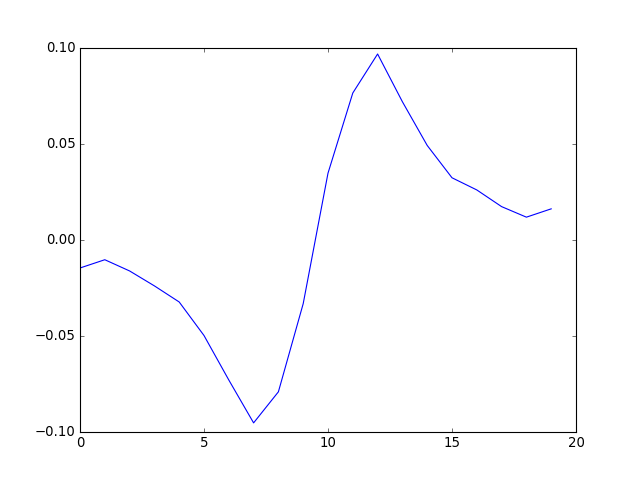

<IPython.core.display.Javascript object>


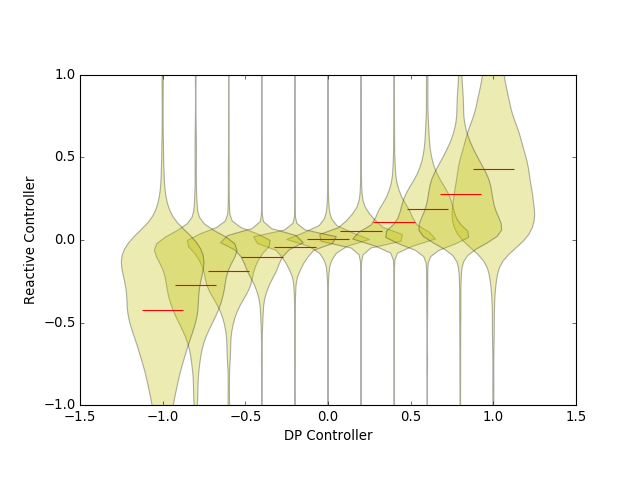

In [14]:
run_linear_regression(X_data, Y_data)

Regression weights for linear features = 
[  6.76168827e-03  -1.10123549e-02   5.02560477e-03   4.35166071e-04
  -2.74368717e-03   2.01923725e-03  -3.59720563e-03   2.85783897e-03
   1.82071565e-03   6.71077481e-03   2.89368848e-02  -6.54018684e-02
   2.81739467e-02  -6.13997680e-03   7.19955456e-03   7.81601497e-04
  -7.12601815e-05  -6.44967387e-04   7.61307382e-04  -3.73630557e-04]
r-value
0.00150010576872


<IPython.core.display.Javascript object>


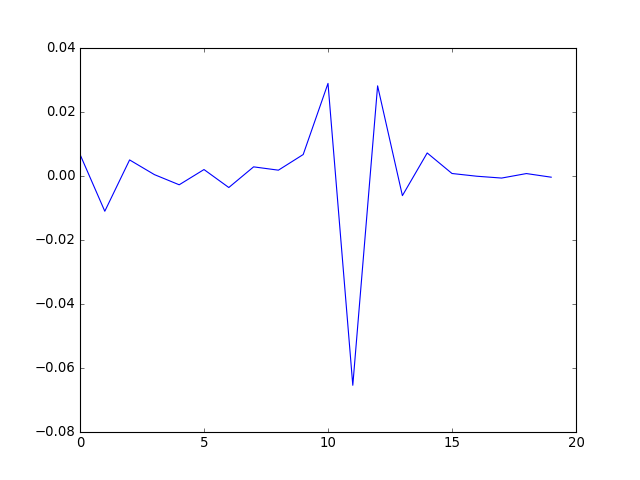

<IPython.core.display.Javascript object>


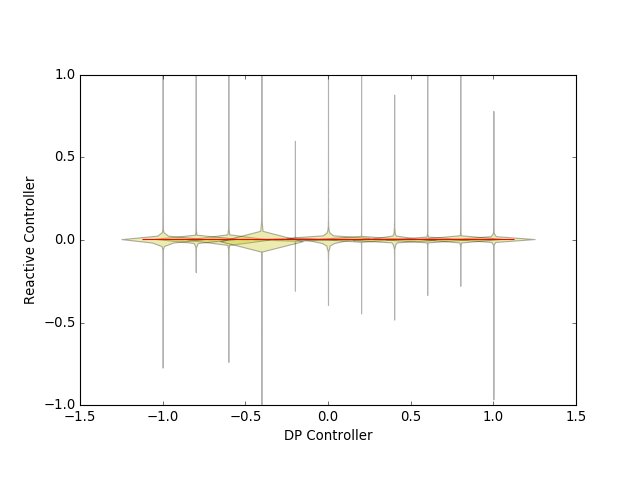

In [15]:
X_features = X_data**(-1)
run_linear_regression(X_features, Y_data)